## Imports

In [1]:
import numpy as np
import cv2
from pathlib import Path
import os
import glob
import h5py
from typing import List

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Load data

In [3]:
def load_vehicle_states(dir: Path, regex="/*.npy") -> List[str]:
    file_paths = sorted(glob.glob((dir.as_posix() + regex)), key=os.path.getmtime)
    return file_paths

def load_images(dir: Path, regex="/*.png") -> List:
    file_paths = sorted(glob.glob((image_dir.as_posix() + regex)), key=os.path.getmtime)
    return file_paths


def load_depth_images(dir, regex="/*.npy") -> List:
    file_paths = sorted(glob.glob((dir.as_posix() + regex)), key=os.path.getmtime)
    return file_paths

def load_data_paths():
    #rgb_images = load_images(Path("../data/output/front_rgb/"), regex="/frame_*")
    vehicle_states_paths = load_vehicle_states(dir=Path("../data/output/vehicle_state"))
    depth_images_paths = load_depth_images(dir=Path("../data/output/front_depth"))
    X = depth_images_paths
    y = vehicle_states_paths
    
    X = np.array(X[0: min(len(X), len(y))])
    y = np.array(y[0: min(len(X), len(y))])
    return X, y

In [4]:
X_paths, y_paths = load_data_paths()
test_ratio = 0.01
length = len(X_paths)
indices = np.random.permutation(length)
num_train = int(length * (1-test_ratio))
training_idx, test_idx = indices[:num_train], indices[num_train:]
X_paths_train, X_paths_test, y_paths_train, y_paths_test = X_paths[training_idx], X_paths[test_idx], y_paths[training_idx], y_paths[test_idx]

print(f"Found {len(X_paths_train)} training and {len(X_paths_test)} testing data for a total of {len(X_paths)}")

Found 4234 training and 43 testing data for a total of 4277


## Data generation

In [5]:
def load_state(fpath):
    state = np.load(fpath, allow_pickle=True)
    return state
def load_depth(fpath):
    image = np.expand_dims(np.load(fpath), -1)
    return image
def generate_data(X_paths, y_paths, batch_size=16, shuffle=True, 
                    aug_likelihood=0.5, 
                    data_aug_pct=0.8, 
                    steering_threshold=0.2, 
                    straight_steer_drop_prob=0.5,
                    straight_steer_cal_prob=0.6,
                     image_width=600, image_height=800, channel=1, num_features=2):
    assert len(X_paths) == len(y_paths), f"Dimension mismatch: Got {len(X_paths)} X but {len(y)} y"
    
    
    batch = np.zeros((batch_size, image_width, image_height, channel), dtype=np.float32)
    labels = np.zeros((batch_size, num_features))
    while True:
        k = 0
        while k < batch_size:
            idx = np.random.randint(0, len(X_paths))
            X_path, y_path = X_paths[idx], y_paths[idx]
            b = load_depth(X_path)
            t_s = load_state(y_path)[-2:]
            t = t_s[0]
            s = t_s[1]
            
            if abs(s) < steering_threshold and np.random.sample() < straight_steer_drop_prob:
                continue
            
            if abs(s) < steering_threshold and np.random.sample() < straight_steer_cal_prob:
                s = s + (np.random.sample() - 0.5) # sample() produces rand num in [0, 1] -> want [-0.5, 0.5]
            batch[k] = b
            labels[k] = [t,s]
            k += 1
        yield batch, np.clip(labels, -1, 1)
    
    

In [6]:
gen = generate_data(X_paths_train, y_paths_train)

In [7]:
batch, label = next(gen)
print(f"Sample batch = {np.shape(batch)} | Sample label = {np.shape(label)}")

Sample batch = (16, 600, 800, 1) | Sample label = (16, 2)


In [8]:
def plot_hist(steerings: np.ndarray, title="Title"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax.grid(True)
    ax.set(title=title)
    count, bins, _ = ax.hist(steerings, bins=25, histtype='bar')
    plt.show()


def show_images(imgs, labels, cols=5, fig_size=(15, 5)):
    rows = len(imgs) // cols
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c]
            img = imgs[cols * r + c] * 255
            lb = labels[cols * r + c]
            ax.imshow(img.astype(np.uint8))
            ax.axis('on')
            ax.set_aspect('equal')
            ax.set(title=lb)
    fig.tight_layout()
    plt.show()


def show_sample_images(X, y):
    gen = generate_images(X=X, y=y, batch_size=20)
    b, s = next(gen)
    show_images(b[0:20], s[0:20])


def plot_results(hist, metrics, xlb, ylb, title, leg, fsize=(10, 5)):
    fig, ax = plt.subplots(1, 1, figsize=fsize)
    for m in metrics:
        ax.plot(hist.history[m])

    ax.set(xlabel=xlb, ylabel=ylb, title=title)
    ax.set_yscale('log')

    ax.legend(leg, loc='upper left')
    plt.show()

## Explore & Analyise data

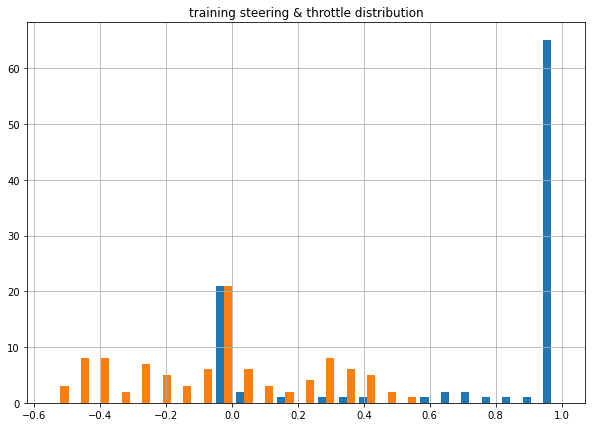

In [9]:
gen = generate_data(X_paths_train, y_paths_train, batch_size=100)
b, control = next(gen)
plot_hist(control,"training steering & throttle distribution")

## Define model & start training

In [10]:
from model import nvidia_model_throttle_steering
m = nvidia_model_throttle_steering(input_shape=(600,800, 1))
batch_size = 16
train_gen = generate_data(X_paths_train, y_paths_train, batch_size)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "nvidia_model_throttle_and_steering.h5", monitor="val_loss", save_best_only=True
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir='depth_nvidia_model_logs', histogram_freq=1, write_graph=True,
        write_images=True, update_freq=1000, profile_batch=2,
        embeddings_freq=0, embeddings_metadata=None)
]

In [11]:
X_tests = np.array([load_depth(X_path)  for X_path in X_paths_test])
y_tests = np.array([load_state(y_path)[-2:] for y_path in y_paths_test])

In [ ]:
history = m.fit(train_gen, 
                verbose=1, 
                callbacks=callbacks, 
                steps_per_epoch = 200, 
                epochs=1000,
                validation_data=(X_tests, y_tests), validation_freq=2)

Epoch 1/1000
200/200 [==============================] - 29s 145ms/step - loss: 0.1442
Epoch 2/1000
200/200 [==============================] - 54s 272ms/step - loss: 0.0690 - val_loss: 0.0583
Epoch 3/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0649
Epoch 4/1000
200/200 [==============================] - 53s 266ms/step - loss: 0.0649 - val_loss: 0.1075
Epoch 5/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0616
Epoch 6/1000
200/200 [==============================] - 53s 263ms/step - loss: 0.0610 - val_loss: 3.6473
Epoch 7/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0618
Epoch 8/1000
200/200 [==============================] - 55s 276ms/step - loss: 0.0617 - val_loss: 0.0484
Epoch 9/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0618
Epoch 10/1000
200/200 [==============================] - 56s 282ms/step - loss: 0.0615 - val_loss: 0.0484
Epoch 11/1000
200/200 [=====================

200/200 [==============================] - 74s 368ms/step - loss: 0.0600 - val_loss: 0.0470
Epoch 41/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0611
Epoch 42/1000
200/200 [==============================] - 72s 360ms/step - loss: 0.0603 - val_loss: 0.0495
Epoch 43/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0603
Epoch 44/1000
200/200 [==============================] - 75s 376ms/step - loss: 0.0602 - val_loss: 0.0470
Epoch 45/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0599
Epoch 46/1000
200/200 [==============================] - 74s 372ms/step - loss: 0.0594 - val_loss: 6.8833
Epoch 47/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0596
Epoch 48/1000
200/200 [==============================] - 73s 366ms/step - loss: 0.0601 - val_loss: 0.0473
Epoch 49/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0602
Epoch 50/1000
200/200 [==========================

Epoch 80/1000
200/200 [==============================] - 80s 401ms/step - loss: 0.0586 - val_loss: 0.0471
Epoch 81/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0613
Epoch 82/1000
200/200 [==============================] - 78s 392ms/step - loss: 0.0594 - val_loss: 0.0484
Epoch 83/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0605
Epoch 84/1000
200/200 [==============================] - 78s 388ms/step - loss: 0.0606 - val_loss: 26.3670
Epoch 85/1000
200/200 [==============================] - 22s 109ms/step - loss: 0.0580
Epoch 86/1000
200/200 [==============================] - 74s 371ms/step - loss: 0.0611 - val_loss: 0.1537
Epoch 87/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0620
Epoch 88/1000
200/200 [==============================] - 60s 302ms/step - loss: 0.0594 - val_loss: 0.0462
Epoch 89/1000
200/200 [==============================] - 22s 109ms/step - loss: 0.0603
Epoch 90/1000
200/200 [===========

200/200 [==============================] - 22s 110ms/step - loss: 0.0583
Epoch 120/1000
200/200 [==============================] - 56s 279ms/step - loss: 0.0577 - val_loss: 0.0453
Epoch 121/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0597
Epoch 122/1000
200/200 [==============================] - 56s 279ms/step - loss: 0.0610 - val_loss: 0.0463
Epoch 123/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0610
Epoch 124/1000
200/200 [==============================] - 56s 279ms/step - loss: 0.0601 - val_loss: 0.0465
Epoch 125/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0621
Epoch 126/1000
200/200 [==============================] - 57s 283ms/step - loss: 0.0589 - val_loss: 0.0462
Epoch 127/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0595
Epoch 128/1000
200/200 [==============================] - 57s 284ms/step - loss: 0.0614 - val_loss: 0.0479
Epoch 129/1000
200/200 [================

200/200 [==============================] - 22s 109ms/step - loss: 0.0589
Epoch 160/1000
200/200 [==============================] - 58s 288ms/step - loss: 0.0604 - val_loss: 0.0490
Epoch 161/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0600
Epoch 162/1000
200/200 [==============================] - 58s 289ms/step - loss: 0.0602 - val_loss: 0.0439
Epoch 163/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0599
Epoch 164/1000
200/200 [==============================] - 58s 288ms/step - loss: 0.0606 - val_loss: 0.0483
Epoch 165/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0617
Epoch 166/1000
200/200 [==============================] - 58s 289ms/step - loss: 0.0593 - val_loss: 0.0496
Epoch 167/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0609
Epoch 168/1000
200/200 [==============================] - 57s 287ms/step - loss: 0.0601 - val_loss: 0.0479
Epoch 169/1000
200/200 [================

200/200 [==============================] - 57s 284ms/step - loss: 0.0608 - val_loss: 0.0481
Epoch 199/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0610
Epoch 200/1000
200/200 [==============================] - 57s 284ms/step - loss: 0.0601 - val_loss: 0.0472
Epoch 201/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0612
Epoch 202/1000
200/200 [==============================] - 57s 284ms/step - loss: 0.0591 - val_loss: 0.0465
Epoch 203/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0617
Epoch 204/1000
200/200 [==============================] - 57s 287ms/step - loss: 0.0606 - val_loss: 0.0478
Epoch 205/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0602
Epoch 206/1000
200/200 [==============================] - 57s 284ms/step - loss: 0.0613 - val_loss: 0.2192
Epoch 207/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0601
Epoch 208/1000
200/200 [================

200/200 [==============================] - 22s 110ms/step - loss: 0.0601
Epoch 238/1000
200/200 [==============================] - 57s 287ms/step - loss: 0.0611 - val_loss: 0.0484
Epoch 239/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0608
Epoch 240/1000
200/200 [==============================] - 57s 286ms/step - loss: 0.0591 - val_loss: 0.0483
Epoch 241/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0588
Epoch 242/1000
200/200 [==============================] - 58s 291ms/step - loss: 0.0614 - val_loss: 0.0688
Epoch 243/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0584
Epoch 244/1000
200/200 [==============================] - 58s 290ms/step - loss: 0.0602 - val_loss: 0.0471
Epoch 245/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0600
Epoch 246/1000
200/200 [==============================] - 58s 289ms/step - loss: 0.0609 - val_loss: 63.2319
Epoch 247/1000
200/200 [===============

200/200 [==============================] - 22s 110ms/step - loss: 0.0594
Epoch 278/1000
200/200 [==============================] - 56s 281ms/step - loss: 0.0593 - val_loss: 0.0447
Epoch 279/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0609
Epoch 280/1000
200/200 [==============================] - 57s 284ms/step - loss: 0.0617 - val_loss: 0.4329
Epoch 281/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0591
Epoch 282/1000
200/200 [==============================] - 57s 284ms/step - loss: 0.0609 - val_loss: 0.0480
Epoch 283/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0607
Epoch 284/1000
200/200 [==============================] - 57s 284ms/step - loss: 0.0606 - val_loss: 0.0468
Epoch 285/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0598
Epoch 286/1000
200/200 [==============================] - 56s 280ms/step - loss: 0.0604 - val_loss: 0.0468
Epoch 287/1000
200/200 [================

200/200 [==============================] - 56s 279ms/step - loss: 0.0604 - val_loss: 0.0466
Epoch 317/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0602
Epoch 318/1000
200/200 [==============================] - 56s 280ms/step - loss: 0.0607 - val_loss: 0.0475
Epoch 319/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0615
Epoch 320/1000
200/200 [==============================] - 56s 279ms/step - loss: 0.0586 - val_loss: 0.0474
Epoch 321/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0594
Epoch 322/1000
200/200 [==============================] - 56s 280ms/step - loss: 0.0611 - val_loss: 0.0465
Epoch 323/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0599
Epoch 324/1000
200/200 [==============================] - 56s 279ms/step - loss: 0.0610 - val_loss: 0.0530
Epoch 325/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0592
Epoch 326/1000
200/200 [================

200/200 [==============================] - 22s 110ms/step - loss: 0.0599
Epoch 356/1000
200/200 [==============================] - 56s 279ms/step - loss: 0.0590 - val_loss: 0.0473
Epoch 357/1000
200/200 [==============================] - 22s 109ms/step - loss: 0.0595
Epoch 358/1000
200/200 [==============================] - 56s 280ms/step - loss: 0.0599 - val_loss: 0.0490
Epoch 359/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0579
Epoch 360/1000
200/200 [==============================] - 56s 282ms/step - loss: 0.0608 - val_loss: 0.0478
Epoch 361/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0599
Epoch 362/1000
200/200 [==============================] - 56s 282ms/step - loss: 0.0607 - val_loss: 0.0477
Epoch 363/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0596
Epoch 364/1000
200/200 [==============================] - 56s 282ms/step - loss: 0.0592 - val_loss: 0.0465
Epoch 365/1000
200/200 [================

200/200 [==============================] - 22s 110ms/step - loss: 0.0607
Epoch 396/1000
200/200 [==============================] - 56s 278ms/step - loss: 0.0603 - val_loss: 0.0478
Epoch 397/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0602
Epoch 398/1000
200/200 [==============================] - 55s 277ms/step - loss: 0.0597 - val_loss: 0.0469
Epoch 399/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0592
Epoch 400/1000
200/200 [==============================] - 56s 278ms/step - loss: 0.0611 - val_loss: 0.0484
Epoch 401/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0597
Epoch 402/1000
200/200 [==============================] - 56s 278ms/step - loss: 0.0599 - val_loss: 0.0482
Epoch 403/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0605
Epoch 404/1000
200/200 [==============================] - 56s 278ms/step - loss: 0.0583 - val_loss: 0.0462
Epoch 405/1000
200/200 [================

200/200 [==============================] - 55s 277ms/step - loss: 0.0587 - val_loss: 0.0467
Epoch 435/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0593
Epoch 436/1000
200/200 [==============================] - 56s 278ms/step - loss: 0.0609 - val_loss: 0.0471
Epoch 437/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0591
Epoch 438/1000
200/200 [==============================] - 55s 277ms/step - loss: 0.0603 - val_loss: 0.0473
Epoch 439/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0619
Epoch 440/1000
200/200 [==============================] - 55s 277ms/step - loss: 0.0596 - val_loss: 0.0470
Epoch 441/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0610
Epoch 442/1000
200/200 [==============================] - 55s 277ms/step - loss: 0.0593 - val_loss: 87063.3177
Epoch 443/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0607
Epoch 444/1000
200/200 [============

200/200 [==============================] - 22s 110ms/step - loss: 0.0616
Epoch 474/1000
200/200 [==============================] - 56s 278ms/step - loss: 0.0585 - val_loss: 0.0459
Epoch 475/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0605
Epoch 476/1000
200/200 [==============================] - 55s 276ms/step - loss: 0.0590 - val_loss: 0.0467
Epoch 477/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0616
Epoch 478/1000
200/200 [==============================] - 55s 276ms/step - loss: 0.0604 - val_loss: 0.0477
Epoch 479/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0602
Epoch 480/1000
200/200 [==============================] - 55s 277ms/step - loss: 0.0608 - val_loss: 0.0467
Epoch 481/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0606
Epoch 482/1000
200/200 [==============================] - 55s 275ms/step - loss: 0.0615 - val_loss: 0.0480
Epoch 483/1000
200/200 [================

200/200 [==============================] - 22s 110ms/step - loss: 0.0609
Epoch 514/1000
200/200 [==============================] - 55s 275ms/step - loss: 0.0585 - val_loss: 1.2217
Epoch 515/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0589
Epoch 516/1000
200/200 [==============================] - 55s 276ms/step - loss: 0.0603 - val_loss: 0.0475
Epoch 517/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0598
Epoch 518/1000
200/200 [==============================] - 55s 275ms/step - loss: 0.0595 - val_loss: 0.2620
Epoch 519/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0598
Epoch 520/1000
200/200 [==============================] - 55s 275ms/step - loss: 0.0600 - val_loss: 0.0475
Epoch 521/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0599
Epoch 522/1000
200/200 [==============================] - 55s 275ms/step - loss: 0.0610 - val_loss: 968.5754
Epoch 523/1000
200/200 [==============

200/200 [==============================] - 55s 273ms/step - loss: 0.0606 - val_loss: 0.0470
Epoch 553/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0603
Epoch 554/1000
200/200 [==============================] - 55s 273ms/step - loss: 0.0593 - val_loss: 0.0464
Epoch 555/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0597
Epoch 556/1000
200/200 [==============================] - 54s 272ms/step - loss: 0.0597 - val_loss: 0.0469
Epoch 557/1000
200/200 [==============================] - 22s 109ms/step - loss: 0.0603
Epoch 558/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.0605 - val_loss: 0.0471
Epoch 559/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0592
Epoch 560/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.0602 - val_loss: 0.0470
Epoch 561/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0613
Epoch 562/1000
200/200 [================

200/200 [==============================] - 22s 110ms/step - loss: 0.0603
Epoch 592/1000
200/200 [==============================] - 54s 272ms/step - loss: 0.0607 - val_loss: 0.0473
Epoch 593/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0588
Epoch 594/1000
200/200 [==============================] - 54s 269ms/step - loss: 0.0619 - val_loss: 0.0484
Epoch 595/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0589
Epoch 596/1000
200/200 [==============================] - 54s 268ms/step - loss: 0.0593 - val_loss: 0.0466
Epoch 597/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0598
Epoch 598/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.0604 - val_loss: 0.0470
Epoch 599/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0601
Epoch 600/1000
200/200 [==============================] - 54s 269ms/step - loss: 0.0599 - val_loss: 0.0466
Epoch 601/1000
200/200 [================

200/200 [==============================] - 22s 109ms/step - loss: 0.0596
Epoch 632/1000
200/200 [==============================] - 54s 269ms/step - loss: 0.0612 - val_loss: 0.8746
Epoch 633/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0600
Epoch 634/1000
200/200 [==============================] - 54s 269ms/step - loss: 0.0604 - val_loss: 0.0470
Epoch 635/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0604
Epoch 636/1000
200/200 [==============================] - 54s 269ms/step - loss: 0.0595 - val_loss: 0.0464
Epoch 637/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0583
Epoch 638/1000
200/200 [==============================] - 54s 269ms/step - loss: 0.0616 - val_loss: 0.0479
Epoch 639/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0603
Epoch 640/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.0600 - val_loss: 0.0467
Epoch 641/1000
200/200 [================

200/200 [==============================] - 54s 271ms/step - loss: 0.0605 - val_loss: 0.0458
Epoch 671/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0608
Epoch 672/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.0611 - val_loss: 0.0463
Epoch 673/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0605
Epoch 674/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.0594 - val_loss: 0.0480
Epoch 675/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0603
Epoch 676/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.0601 - val_loss: 0.0458
Epoch 677/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0595
Epoch 678/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.0595 - val_loss: 113.5214
Epoch 679/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0602
Epoch 680/1000
200/200 [==============

200/200 [==============================] - 22s 110ms/step - loss: 0.0593
Epoch 710/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.0598 - val_loss: 0.0477
Epoch 711/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0611
Epoch 712/1000
200/200 [==============================] - 54s 269ms/step - loss: 0.0603 - val_loss: 0.0470
Epoch 713/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0602
Epoch 714/1000
200/200 [==============================] - 54s 271ms/step - loss: 0.0600 - val_loss: 15.4116
Epoch 715/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0592
Epoch 716/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.0608 - val_loss: 0.0464
Epoch 717/1000
200/200 [==============================] - 22s 110ms/step - loss: 0.0591
Epoch 718/1000
200/200 [==============================] - 55s 273ms/step - loss: 0.0601 - val_loss: 149.0296
Epoch 719/1000
200/200 [=============

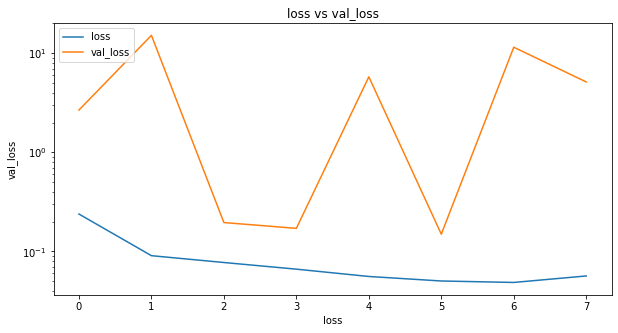

In [21]:

plot_results(history, ["loss", "val_loss"], "loss", "val_loss", "loss vs val_loss", ["loss", "val_loss"])

## Evaluate model

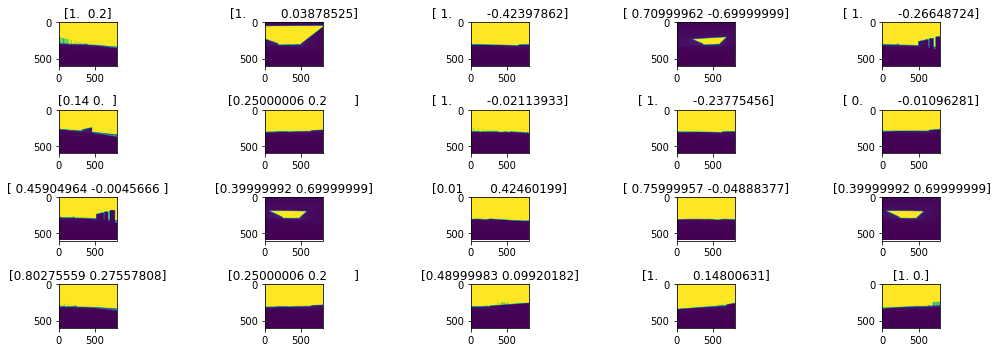

In [13]:
gen_val = generate_images(X_test, y_test, batch_size)
batch, steerings = next(gen_val)
show_images(batch[0:20], steerings[0:20])

In [14]:
predictions = np.array(m.predict(batch[0:20])).squeeze()
predictions = predictions.squeeze()
print(predictions)

[[ 0.33575627  0.3350542 ]
 [ 0.42153466 -0.12509304]
 [ 0.42961594  0.09497067]
 [ 0.52219    -0.21547362]
 [ 0.37239212  0.08458566]
 [ 0.15578039  0.31990615]
 [ 0.24405767  0.07524973]
 [ 0.11092788  0.37889016]
 [ 0.6845945   0.11776495]
 [ 0.24191844 -0.11903911]
 [ 0.0453493  -0.07521864]
 [ 0.3854706  -0.294028  ]
 [ 0.01533835  0.3077331 ]
 [ 0.23651096  0.30365494]
 [ 0.3854706  -0.294028  ]
 [ 0.4121667   0.14179194]
 [ 0.24405767  0.07524973]
 [ 0.22273293 -0.21498868]
 [ 0.15311469 -0.08078137]
 [ 0.37344056 -0.09682245]]


In [15]:
np.sqrt(sum((predictions - steerings[0:20]) ** 2))

array([2.06362296, 1.84429802])

In [16]:
m.save("depth_model_1.h5")

In [17]:
m = tf.keras.models.load_model("depth_nvidia_model.h5")

ResourceExhaustedError: OOM when allocating tensor with shape[404736,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add]

In [ ]:
m.predict(data)

In [ ]:
y[0]